In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('sensex.csv')

In [2]:
print(df.head())

        Price        Close         High          Low         Open  Volume
0        Date          NaN          NaN          NaN          NaN     NaN
1  1997-07-01  4300.859863  4301.770020  4247.660156  4263.109863     0.0
2  1997-07-02  4333.899902  4395.310059  4295.399902  4302.959961     0.0
3  1997-07-03  4323.459961  4393.290039  4299.970215  4335.790039     0.0
4  1997-07-04  4323.819824  4347.589844  4300.580078  4332.700195     0.0


In [3]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

print("\nDataFrame after processing the Date column:")
print(df.head())


DataFrame after processing the Date column:
        Price        Close         High          Low         Open  Volume
0        Date          NaN          NaN          NaN          NaN     NaN
1  1997-07-01  4300.859863  4301.770020  4247.660156  4263.109863     0.0
2  1997-07-02  4333.899902  4395.310059  4295.399902  4302.959961     0.0
3  1997-07-03  4323.459961  4393.290039  4299.970215  4335.790039     0.0
4  1997-07-04  4323.819824  4347.589844  4300.580078  4332.700195     0.0


In [4]:
df['Daily_Return'] = df['Close'].pct_change() * 100

# Define a threshold for a daily crash (e.g., drop more than 5%)
crash_threshold_daily = -5
df['Crash_Daily'] = df['Daily_Return'] <= crash_threshold_daily

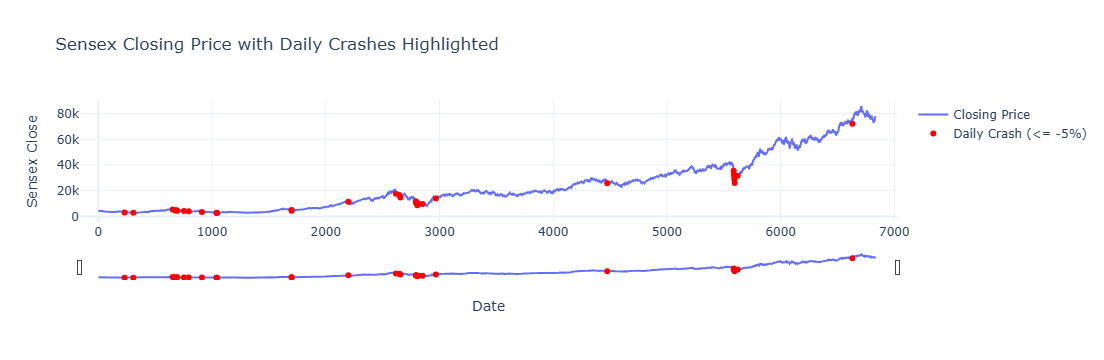

In [5]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price'))

crash_days = df.index[df['Crash_Daily']]
crash_closes = df['Close'][df['Crash_Daily']]

fig.add_trace(go.Scatter(x=crash_days, y=crash_closes, mode='markers',
                          marker=dict(color='red'),
                          name=f'Daily Crash (<= {crash_threshold_daily}%)'))

fig.update_layout(
    title='Sensex Closing Price with Daily Crashes Highlighted',
    xaxis_title='Date',
    yaxis_title='Sensex Close',
    xaxis_rangeslider_visible=True,  
    template="plotly_white" 

)

fig.show()

In [6]:
# Calculate cumulative max and drawdown (% drop from the cumulative max)
df['Cumulative_Max'] = df['Close'].cummax()
df['Drawdown'] = (df['Close'] - df['Cumulative_Max']) / df['Cumulative_Max'] * 100

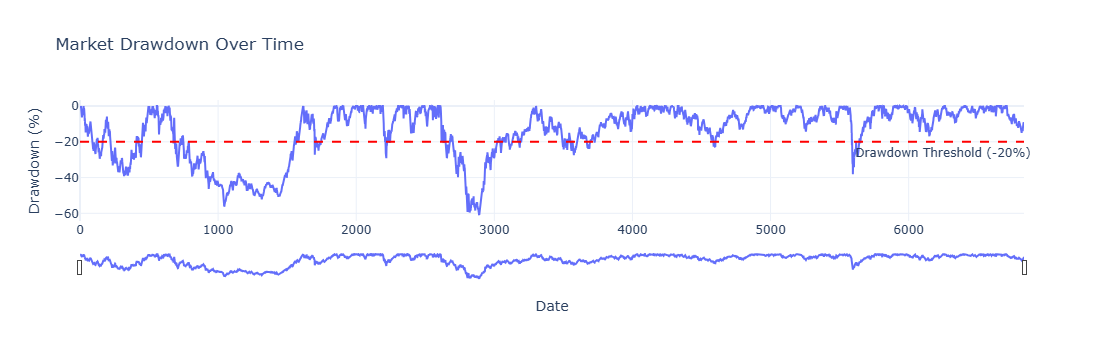

In [7]:
drawdown_threshold = -20
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Drawdown'], mode='lines', name='Drawdown (%)'))

fig.add_hline(y=drawdown_threshold, line_dash='dash', line_color='red',
              annotation_text=f'Drawdown Threshold ({drawdown_threshold}%)',
              annotation_position='bottom right')

fig.update_layout(
    title='Market Drawdown Over Time',
    xaxis_title='Date',
    yaxis_title='Drawdown (%)',
    xaxis_rangeslider_visible=True,  
    template="plotly_white"
)

fig.show()

In [8]:
crash_drawdowns = df[df['Drawdown'] <= drawdown_threshold]
print("Dates where drawdown exceeded threshold:")
print(crash_drawdowns[['Close', 'Cumulative_Max', 'Drawdown']].dropna().head(10))

Dates where drawdown exceeded threshold:
          Close  Cumulative_Max   Drawdown
90  3633.179932      4548.02002 -20.115129
91  3554.100098      4548.02002 -21.853904
92  3569.770020      4548.02002 -21.509360
93  3578.100098      4548.02002 -21.326202
94  3518.899902      4548.02002 -22.627871
95  3454.649902      4548.02002 -24.040574
96  3466.860107      4548.02002 -23.772101
97  3523.439941      4548.02002 -22.528047
98  3403.070068      4548.02002 -25.174690
99  3479.889893      4548.02002 -23.485607


In [9]:
crash_drawdowns = df[df['Drawdown'] <= drawdown_threshold]
print("Dates where drawdown exceeded threshold:")
print(crash_drawdowns[['Close', 'Cumulative_Max', 'Drawdown']].dropna().reset_index().head(10))

Dates where drawdown exceeded threshold:
   index        Close  Cumulative_Max   Drawdown
0     90  3633.179932      4548.02002 -20.115129
1     91  3554.100098      4548.02002 -21.853904
2     92  3569.770020      4548.02002 -21.509360
3     93  3578.100098      4548.02002 -21.326202
4     94  3518.899902      4548.02002 -22.627871
5     95  3454.649902      4548.02002 -24.040574
6     96  3466.860107      4548.02002 -23.772101
7     97  3523.439941      4548.02002 -22.528047
8     98  3403.070068      4548.02002 -25.174690
9     99  3479.889893      4548.02002 -23.485607


In [10]:
crash_drawdowns = df[df['Drawdown'] <= drawdown_threshold].copy()
# Ensure the index is converted to datetime if it's not already
crash_drawdowns.index = pd.to_datetime(crash_drawdowns.index)
crash_dates = crash_drawdowns.index  # Now these should be datetime objects

clusters = []
current_cluster = []

for date in crash_dates:
    if not current_cluster:
        current_cluster.append(date)
    else:
        if (date - current_cluster[-1]).days <= 3:
            current_cluster.append(date)
        else:
            clusters.append(current_cluster)
            current_cluster = [date]
if current_cluster:
    clusters.append(current_cluster)

print("Identified crash clusters based on drawdown threshold:")
for idx, cluster in enumerate(clusters):
    print(f"Cluster {idx+1}: {cluster[0].date()} to {cluster[-1].date()} (Total days: {len(cluster)})")

Identified crash clusters based on drawdown threshold:
Cluster 1: 1970-01-01 to 1970-01-01 (Total days: 1747)


In [11]:
print(df.columns.tolist())  # Show all column names
print(df.head())  # Show first few rows

['Price', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Crash_Daily', 'Cumulative_Max', 'Drawdown']
        Price        Close         High          Low         Open  Volume  \
0        Date          NaN          NaN          NaN          NaN     NaN   
1  1997-07-01  4300.859863  4301.770020  4247.660156  4263.109863     0.0   
2  1997-07-02  4333.899902  4395.310059  4295.399902  4302.959961     0.0   
3  1997-07-03  4323.459961  4393.290039  4299.970215  4335.790039     0.0   
4  1997-07-04  4323.819824  4347.589844  4300.580078  4332.700195     0.0   

   Daily_Return  Crash_Daily  Cumulative_Max  Drawdown  
0           NaN        False             NaN       NaN  
1           NaN        False     4300.859863  0.000000  
2      0.768219        False     4333.899902  0.000000  
3     -0.240890        False     4333.899902 -0.240890  
4      0.008324        False     4333.899902 -0.232587  


In [12]:
import pandas as pd

# Clean the DataFrame first - remove the first row which contains "Date"
df = df.iloc[1:].copy()

# Rename the first column to 'Date' (it's currently unnamed)
df = df.rename(columns={df.columns[0]: 'Date'})

# Get the crash periods
crash_drawdowns = df[df['Drawdown'] <= drawdown_threshold].copy()

# Convert to datetime and set as index
crash_drawdowns['Date'] = pd.to_datetime(crash_drawdowns['Date'])
crash_drawdowns = crash_drawdowns.set_index('Date').sort_index()

# Now proceed with clustering logic
clusters = []
current_cluster = []

for date in crash_drawdowns.index:
    if not current_cluster:
        current_cluster.append(date)
    else:
        if (date - current_cluster[-1]).days <= 3:
            current_cluster.append(date)
        else:
            if len(current_cluster) > 0:
                clusters.append(current_cluster)
            current_cluster = [date]

if current_cluster:
    clusters.append(current_cluster)

# Print results
print("Identified crash clusters based on drawdown threshold:")
for idx, cluster in enumerate(clusters, 1):
    print(f"Cluster {idx}: {cluster[0].date()} to {cluster[-1].date()} (Total days: {len(cluster)})")

Identified crash clusters based on drawdown threshold:
Cluster 1: 1997-11-12 to 1997-12-26 (Total days: 31)
Cluster 2: 1997-12-30 to 1997-12-30 (Total days: 1)
Cluster 3: 1998-01-08 to 1998-01-23 (Total days: 12)
Cluster 4: 1998-01-27 to 1998-01-29 (Total days: 3)
Cluster 5: 1998-02-02 to 1998-02-27 (Total days: 19)
Cluster 6: 1998-06-02 to 1998-09-30 (Total days: 86)
Cluster 7: 1998-10-05 to 1998-12-24 (Total days: 56)
Cluster 8: 1998-12-28 to 1998-12-31 (Total days: 4)
Cluster 9: 1999-01-04 to 1999-03-04 (Total days: 40)
Cluster 10: 1999-03-26 to 1999-03-26 (Total days: 1)
Cluster 11: 1999-04-05 to 1999-04-29 (Total days: 18)
Cluster 12: 1999-05-03 to 1999-05-05 (Total days: 3)
Cluster 13: 2000-04-04 to 2000-04-04 (Total days: 1)
Cluster 14: 2000-04-18 to 2000-04-20 (Total days: 3)
Cluster 15: 2000-04-24 to 2000-04-28 (Total days: 5)
Cluster 16: 2000-05-02 to 2000-06-15 (Total days: 33)
Cluster 17: 2000-06-21 to 2000-06-28 (Total days: 5)
Cluster 18: 2000-07-18 to 2000-08-31 (Total d


Zooming into crash cluster from 1997-11-12 to 1997-12-26


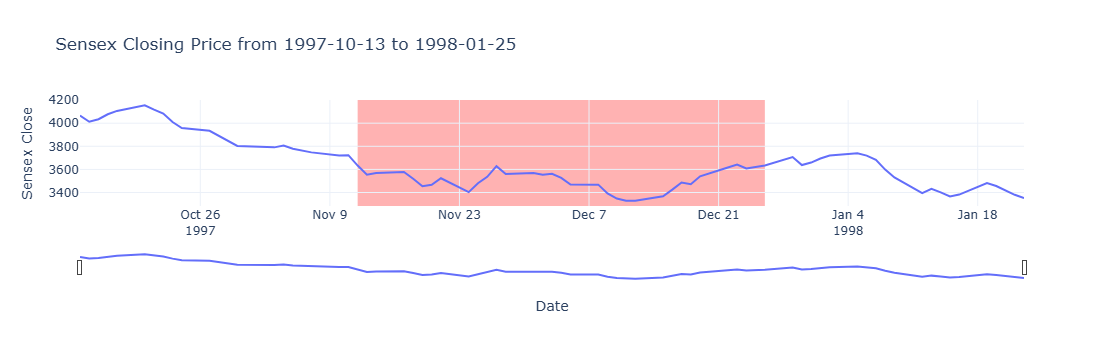

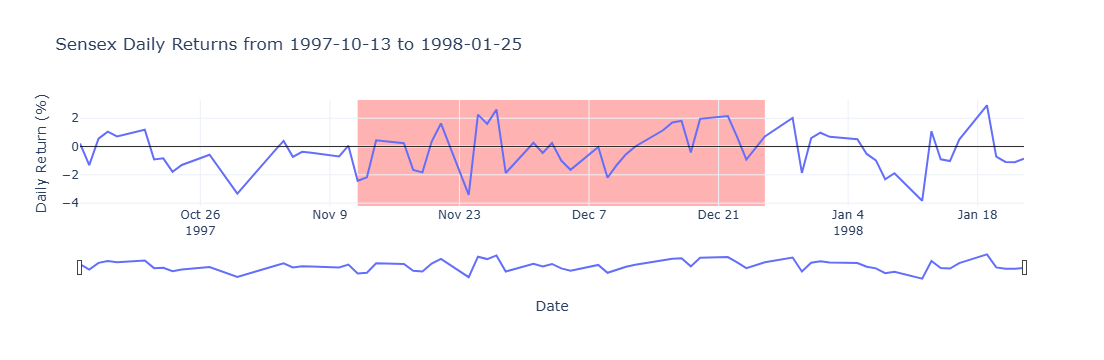

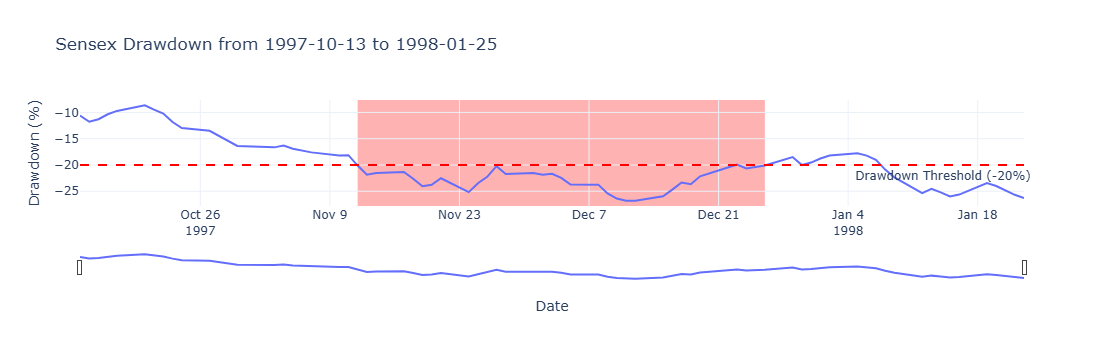

In [13]:
if clusters:
    cluster_start = clusters[0][0]
    cluster_end = clusters[0][-1]
    print(f"\nZooming into crash cluster from {cluster_start.date()} to {cluster_end.date()}")

    # Ensure df has a proper datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # If dates are in a column (as per previous fixes)
        df = df.set_index(pd.to_datetime(df['Date']))
    
    # Convert to same timezone if needed (remove tzinfo if present)
    cluster_start = cluster_start.replace(tzinfo=None)
    cluster_end = cluster_end.replace(tzinfo=None)
    
    # Calculate zoom window
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    
    # Handle edge cases where zoom period might be out of bounds
    zoom_start = max(zoom_start, df.index.min())
    zoom_end = min(zoom_end, df.index.max())
    
    # Get the zoomed data
    zoom_df = df.loc[zoom_start:zoom_end].copy()
    
    # Create figures only if we have data
    if not zoom_df.empty:
        fig_close = go.Figure()
        fig_close.add_trace(go.Scatter(
            x=zoom_df.index, 
            y=zoom_df['Close'], 
            mode='lines', 
            name='Closing Price'
        ))
        fig_close.add_vrect(
            x0=cluster_start, 
            x1=cluster_end, 
            fillcolor='red', 
            opacity=0.3, 
            layer='below', 
            line_width=0, 
            name='Crash Period'
        )
        fig_close.update_layout(
            title=f'Sensex Closing Price from {zoom_start.date()} to {zoom_end.date()}',
            xaxis_title='Date',
            yaxis_title='Sensex Close',
            xaxis_rangeslider_visible=True,
            template="plotly_white"
        )
        fig_close.show()

        fig_returns = go.Figure()
        fig_returns.add_trace(go.Scatter(
            x=zoom_df.index, 
            y=zoom_df['Daily_Return'], 
            mode='lines', 
            name='Daily Return (%)'
        ))
        fig_returns.add_hline(y=0, line_color='black', line_width=0.8)
        fig_returns.add_vrect(
            x0=cluster_start, 
            x1=cluster_end, 
            fillcolor='red', 
            opacity=0.3, 
            layer='below', 
            line_width=0, 
            name='Crash Period'
        )
        fig_returns.update_layout(
            title=f'Sensex Daily Returns from {zoom_start.date()} to {zoom_end.date()}',
            xaxis_title='Date',
            yaxis_title='Daily Return (%)',
            xaxis_rangeslider_visible=True,
            template="plotly_white"
        )
        fig_returns.show()

        fig_drawdown = go.Figure()
        fig_drawdown.add_trace(go.Scatter(
            x=zoom_df.index, 
            y=zoom_df['Drawdown'], 
            mode='lines', 
            name='Drawdown (%)'
        ))
        fig_drawdown.add_hline(
            y=drawdown_threshold, 
            line_dash='dash', 
            line_color='red',
            annotation_text=f'Drawdown Threshold ({drawdown_threshold}%)',
            annotation_position='bottom right'
        )
        fig_drawdown.add_vrect(
            x0=cluster_start, 
            x1=cluster_end, 
            fillcolor='red', 
            opacity=0.3, 
            layer='below', 
            line_width=0, 
            name='Crash Period'
        )
        fig_drawdown.update_layout(
            title=f'Sensex Drawdown from {zoom_start.date()} to {zoom_end.date()}',
            xaxis_title='Date',
            yaxis_title='Drawdown (%)',
            xaxis_rangeslider_visible=True,
            template="plotly_white"
        )
        fig_drawdown.show()
    else:
        print("No data available for the selected zoom period.")
else:
    print("No crash clusters identified based on the drawdown threshold.")

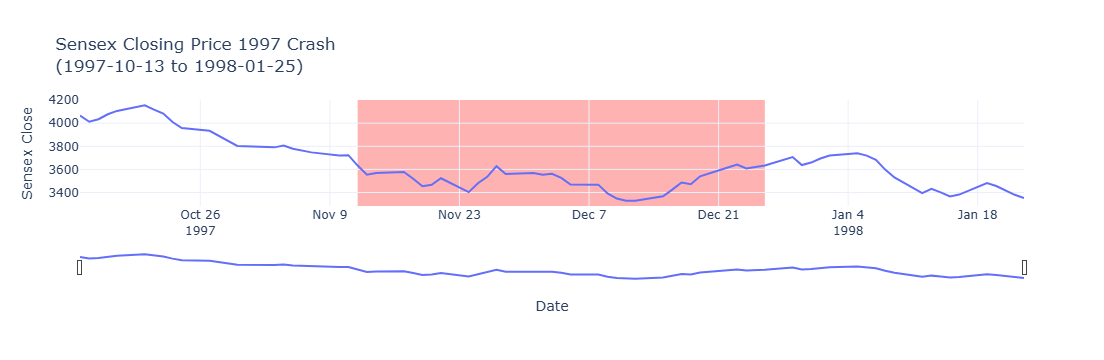

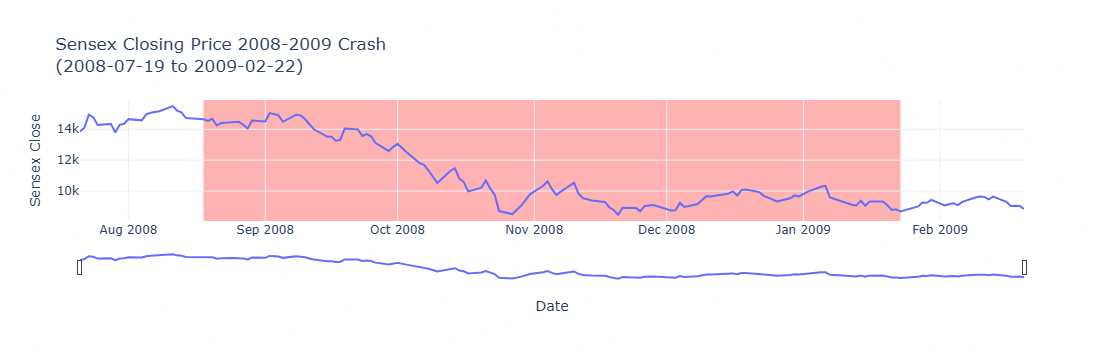

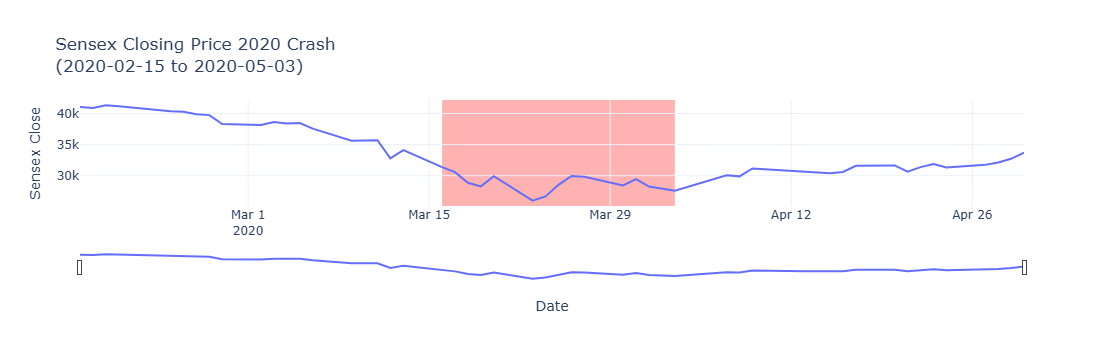

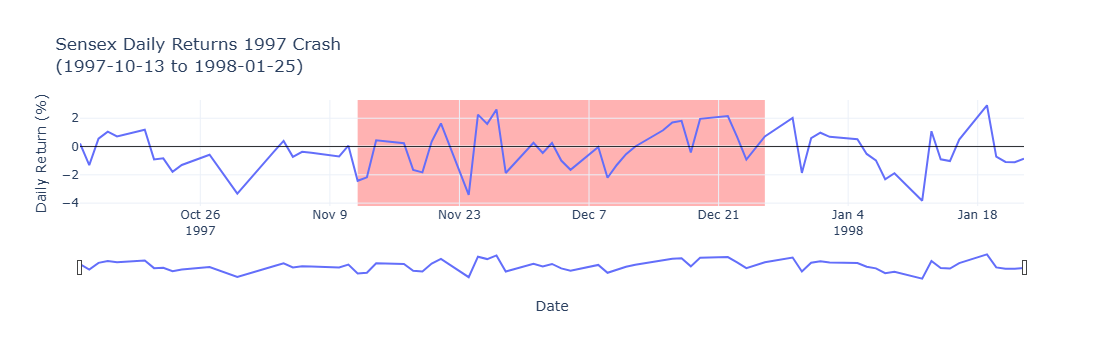

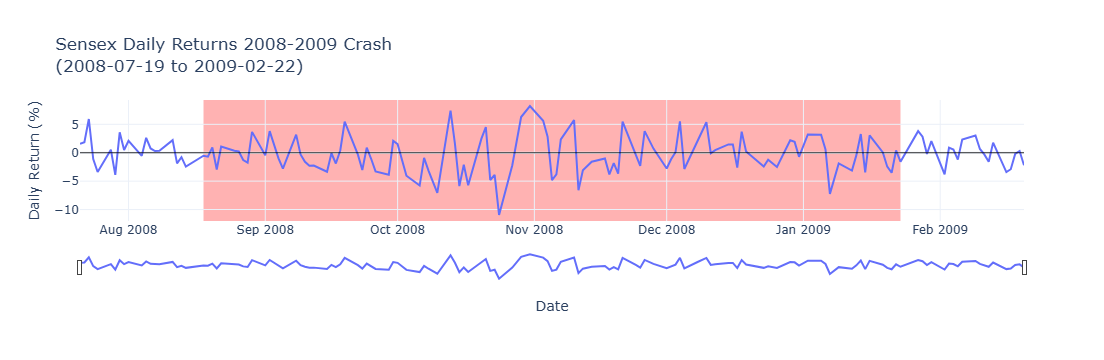

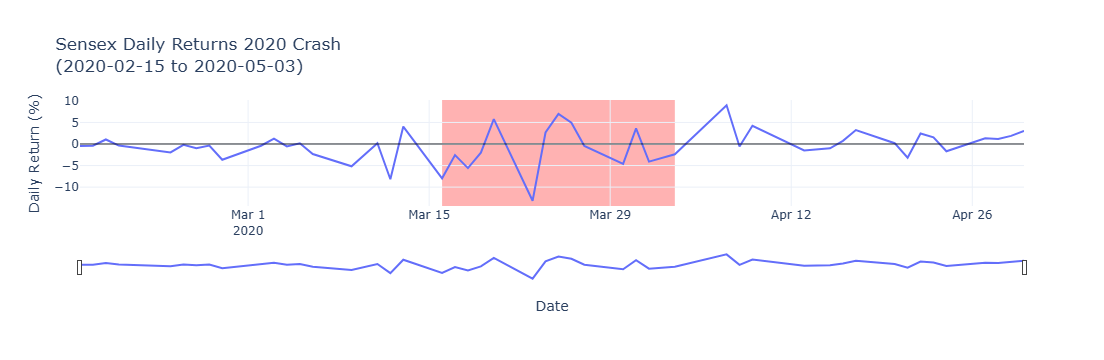

In [14]:
# Define the clusters
cluster1_start = pd.to_datetime("1997-11-12")
cluster1_end = pd.to_datetime("1997-12-26")

cluster49_start = pd.to_datetime("2008-08-18")
cluster49_end = pd.to_datetime("2009-01-23")

cluster79_start = pd.to_datetime("2020-03-16")
cluster79_end = pd.to_datetime("2020-04-03")

def plot_crash_period(cluster_start, cluster_end, title_suffix=""):
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    zoom_df = df.loc[zoom_start:zoom_end]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=zoom_df.index, y=zoom_df['Close'], mode='lines', name='Closing Price'))
    fig.add_vrect(x0=cluster_start, x1=cluster_end, fillcolor='red', opacity=0.3, layer='below', line_width=0, name='Crash Period')
    fig.update_layout(
        title=f'Sensex Closing Price {title_suffix}<br>({zoom_start.date()} to {zoom_end.date()})',
        xaxis_title='Date',
        yaxis_title='Sensex Close',
        xaxis_rangeslider_visible=True,
        template="plotly_white"
    )
    fig.show()

def plot_daily_returns(cluster_start, cluster_end, title_suffix=""):
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    zoom_df = df.loc[zoom_start:zoom_end]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=zoom_df.index, y=zoom_df['Daily_Return'], mode='lines', name='Daily Return (%)'))
    fig.add_hline(y=0, line_color='black', line_width=0.8)
    fig.add_vrect(x0=cluster_start, x1=cluster_end, fillcolor='red', opacity=0.3, layer='below', line_width=0, name='Crash Period')
    fig.update_layout(
        title=f'Sensex Daily Returns {title_suffix}<br>({zoom_start.date()} to {zoom_end.date()})',
        xaxis_title='Date',
        yaxis_title='Daily Return (%)',
        xaxis_rangeslider_visible=True,
        template="plotly_white"
    )
    fig.show()

# Plot for each crash period
plot_crash_period(cluster1_start, cluster1_end, "1997 Crash")
plot_crash_period(cluster49_start, cluster49_end, "2008-2009 Crash")
plot_crash_period(cluster79_start, cluster79_end, "2020 Crash")

# Plot daily returns for each crash period
plot_daily_returns(cluster1_start, cluster1_end, "1997 Crash")
plot_daily_returns(cluster49_start, cluster49_end, "2008-2009 Crash")
plot_daily_returns(cluster79_start, cluster79_end, "2020 Crash")

In [15]:
np.random.seed(42)

dates_2025 = pd.bdate_range(start="2025-01-01", periods=250)

daily_returns = np.zeros(250)
daily_returns[:150] = np.random.normal(loc=0.0005, scale=0.01, size=150)
daily_returns[150:200] = np.random.normal(loc=-0.008, scale=0.025, size=50)
daily_returns[200:] = np.random.normal(loc=0.0005, scale=0.01, size=50)

prices = [30000]
for ret in daily_returns:
    prices.append(prices[-1]*(1+ret))
prices = prices[1:]

df_2025 = pd.DataFrame({
    'Date': dates_2025,
    'Close': prices,
    'Daily_Return': daily_returns * 100 
})
df_2025.set_index('Date', inplace=True)

In [16]:
df_2025['Rolling_Mean_Return'] = df_2025['Daily_Return'].rolling(window=10).mean()
df_2025['Rolling_Volatility'] = df_2025['Daily_Return'].rolling(window=10).std()

warning_condition = (df_2025['Rolling_Mean_Return'] < -0.5) & (df_2025['Rolling_Volatility'] > 2)
df_2025['Warning'] = warning_condition

warnings_df = df_2025[df_2025['Warning']]
print("Early Warning Signals for 2025:")
print(warnings_df[['Close', 'Daily_Return', 'Rolling_Mean_Return', 'Rolling_Volatility']].head(15))

Early Warning Signals for 2025:
                   Close  Daily_Return  Rolling_Mean_Return  \
Date                                                          
2025-08-13  26293.754799     -3.236704            -0.723106   
2025-08-14  26600.790000      1.167712            -0.612947   
2025-08-29  25310.851435     -0.992754            -0.676806   
2025-09-02  25296.816487     -0.108273            -0.558018   
2025-09-04  25420.955891     -0.767495            -0.656682   
2025-09-23  23735.864103     -4.587118            -1.372651   
2025-09-25  23593.214467      1.340997            -1.212308   
2025-09-29  22609.672636     -3.914347            -1.323114   
2025-09-30  22526.684356     -0.367048            -1.223953   

            Rolling_Volatility  
Date                            
2025-08-13            2.316762  
2025-08-14            2.383681  
2025-08-29            2.373521  
2025-09-02            2.146429  
2025-09-04            2.130037  
2025-09-23            2.003797  
2025-09-25

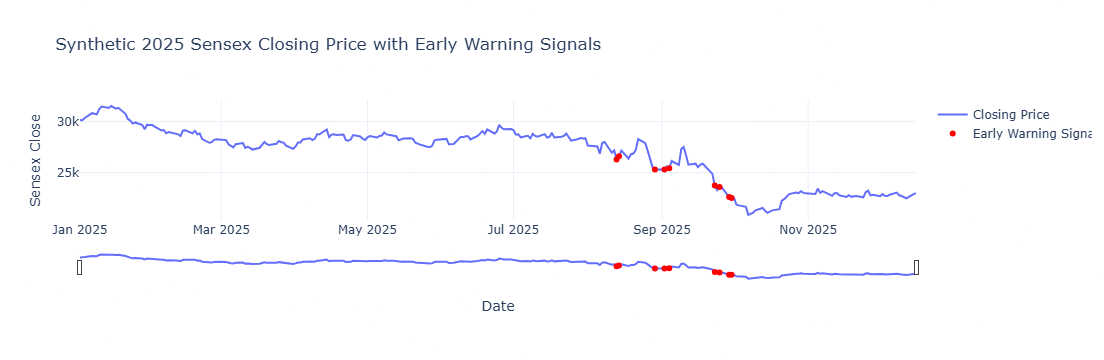

In [17]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_2025.index, y=df_2025['Close'], mode='lines', name='Closing Price'))

warning_dates = df_2025.index[df_2025['Warning']]
warning_closes = df_2025['Close'][df_2025['Warning']]

fig.add_trace(go.Scatter(x=warning_dates, y=warning_closes, mode='markers',
                          marker=dict(color='red'),
                          name='Early Warning Signal'))

fig.update_layout(
    title='Synthetic 2025 Sensex Closing Price with Early Warning Signals',
    xaxis_title='Date',
    yaxis_title='Sensex Close',
    xaxis_rangeslider_visible=True, 
    template="plotly_white"
)
fig.show()